# Bike Sharing challange

In this notebook I will attempt to solve the bike sharing challange.<br>
See https://www.kaggle.com/c/bike-sharing-demand for further information.<br>
<br>
Since the data has very clear seasonality, I will not treat this as a TSA problem.

## Introduction

**Feature engineering:**<br>
I will create relevant time features based on what I concluded in the EDA.
<br><br>
**Modeling:**<br>
1. I will start from a naiv baseline of simple linear regression on 1 feature which shows high correlation to make sure that my models are indeed improving on the naiv.
2. I then will proceed to use XGBoost and Random Forest models with their default parameters and compare their results.
3. I will test the two with different random seeds.
4. I will use TPOT to find the best model and hyper parameters.
5. I will create an xboost model based on the TPOT results.
6. I will create another Random Forest model which uses similar hyper parameters for comparison.
7. I will create an xgboost model with the TPOT hyper paramers and cosine annealing learning rate.
8. I will create a nested model which uses two xgboost TPOT sub models to predict registered and casual, add the results and this will be the count prediction.

**Known limitations:**
- #3: I did not test with more random seeds - this can be treated as another hyper parameter to optimize.
- #4: You can allwas do more...
- #6: Rando Forests hyper parameters are not exactly parallel to those of xgboost.
- #7: I wanted to try SGDR, but this requires more implementation time for xgboost.
- #8: I did not run seperate TPOT for both models, I used the previous TPOT.
- #8: calculating CV with the relevant evaluation metric for this model requires implementation, I skipped this and used just a simple RMSLE for the train and eval sets.


## EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
combine = [df_train, df_test]

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [5]:
df_train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [6]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


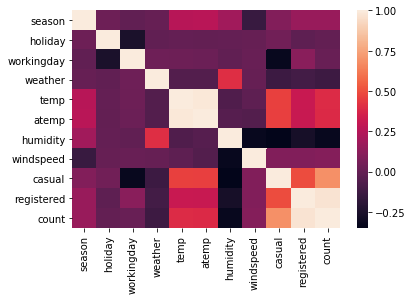

In [7]:
sns.heatmap(df_train.corr())

Interesting insights from the HeatMap:
- casual has a negative correlation with workingday
- high correlation betwen casual and count
- humidity has negative correlation with casual, registered and count.
- temp and atemp have high correlation with count and casual

What I would like to see that does not show up here:
- correlation between year and count (we will probably need a kendal os spearman correlation dut to nonlinearity)
- correlation between season and deviation from yearly average

In [8]:
#datetimable_df = df_train.replace(df_train['datetime'],pd.to_datetime(df_train['datetime']))

In [9]:
df_train[['datetime']] = df_train[['datetime']].apply(pd.to_datetime)
df_test[['datetime']] = df_test[['datetime']].apply(pd.to_datetime)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


(array([ 734107.,  734197.,  734289.,  734381.,  734472.,  734563.,
         734655.,  734747.,  734838.]), <a list of 9 Text xticklabel objects>)

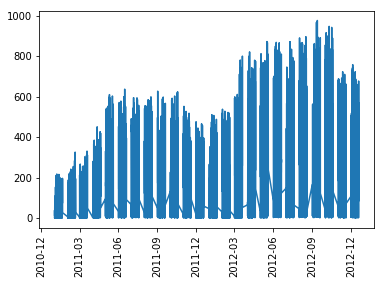

In [11]:
df_train = df_train.sort_values('datetime', ascending=True)
plt.plot(df_train['datetime'], df_train['count'])
plt.xticks(rotation='vertical')

Show significance between mean in 2011 to mean in 2012?

In [12]:
def plot_log_reg_mean(predictor, target, minimum, maximum):
    by_mean = df_train[(df_train[predictor] > minimum) & (df_train[predictor] < maximum)][[predictor, target]].groupby([predictor], as_index=False).mean()
    by_mean.info()
    sns.regplot(x=by_mean[predictor], y=by_mean[target])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 2 columns):
humidity    74 non-null int64
count       74 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


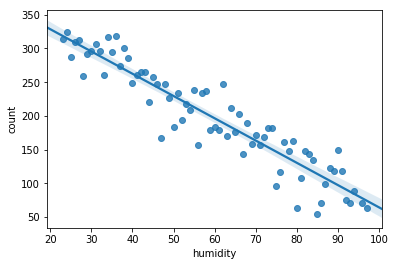

In [13]:
# count_humid = df_train[df_train['humidity'] > 22][['humidity','count']].groupby(['humidity'], as_index=False).mean()
# count_humid.info()
# sns.regplot(x=count_humid['humidity'], y=count_humid['count'])
plot_log_reg_mean('humidity','count', 22, 100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 2 columns):
temp     49 non-null float64
count    49 non-null float64
dtypes: float64(2)
memory usage: 1.1 KB


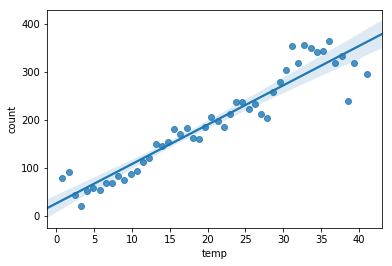

In [14]:
plot_log_reg_mean('temp', 'count', 0,50)

TODO:
> - check for missing data
> - check for skewed variables
> - split date into year and day
> - create vatiable for deviation from yearly average (problematic because this is a time series)
> - change below variables to categorical

Make sure there are no nans:

In [15]:
df_train.isnull().values.any() and df_test.isnull().values.any()

False

check for skewed variables:

In [16]:
def plot_hist_with_log1p(feature):
    fig, ax =plt.subplots(1,2)
    sns.distplot(np.log1p(df_train[feature]), kde=False, ax=ax[0])
    sns.distplot(df_train[feature], kde=False, ax=ax[1])
    fig.show()

C:\Anaconda3\envs\deeplearning\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


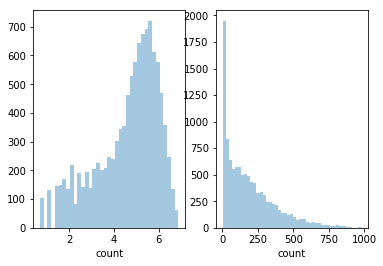

In [17]:
plot_hist_with_log1p('count')

C:\Anaconda3\envs\deeplearning\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


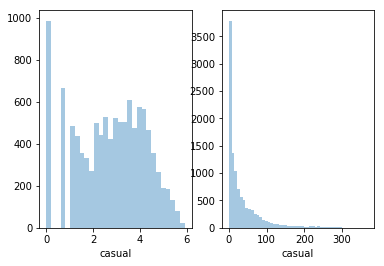

In [18]:
plot_hist_with_log1p('casual')

C:\Anaconda3\envs\deeplearning\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


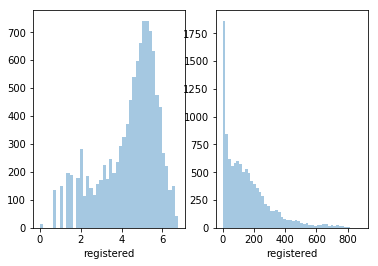

In [19]:
plot_hist_with_log1p('registered')

possible categorical variables:
- season
- datetime - separate the year and month
- weather

## Feature Engineering

Two main things we will do here:
1. split datetime
2. get rid of casual and registered in  train set

In [20]:
def split_datetime(df):
    df['year'] = df['datetime'].map(lambda x: x.year)
    df['month'] = df['datetime'].map(lambda x: x.month)
    df['hour'] = df['datetime'].map(lambda x: x.hour)
    df['weekday'] = df['datetime'].map(lambda x: x.weekday())
    return df

In [21]:
df_train = split_datetime(df_train)
df_train_with_datetime_casual_registered = df_train.copy()
df_train.drop(columns=['datetime', 'casual', 'registered'], inplace=True)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 13 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
count         10886 non-null int64
year          10886 non-null int64
month         10886 non-null int64
hour          10886 non-null int64
weekday       10886 non-null int64
dtypes: float64(3), int64(10)
memory usage: 1.2 MB


In [23]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4,5


Boxplots for days of the week vs count:

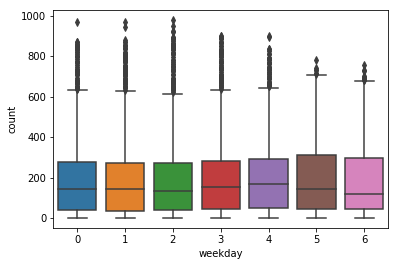

In [24]:
sns.boxplot(x=df_train['weekday'], y=df_train['count'])

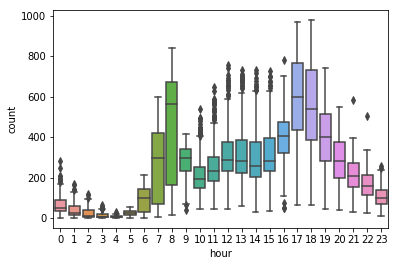

In [25]:
sns.boxplot(x=df_train[df_train.year != 2011]['hour'], y=df_train['count'])

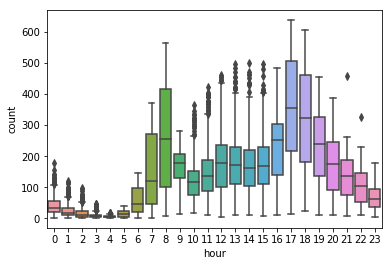

In [26]:
sns.boxplot(x=df_train[df_train.year != 2012]['hour'], y=df_train['count'])

We can see here that count follows a clear pattern:<br>
Down during night, up during rush hours, and medium during the day

In [27]:
df_train.workingday.unique()

array([0, 1], dtype=int64)

In [28]:
df_train.year.unique()

array([2011, 2012], dtype=int64)

In [29]:
df_test = split_datetime(df_test)
df_test_with_datetime_casual_registered = df_test.copy()
test_datetime = df_test['datetime']
df_test.drop(columns=['datetime'], inplace=True)

In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
year          6493 non-null int64
month         6493 non-null int64
hour          6493 non-null int64
weekday       6493 non-null int64
dtypes: float64(3), int64(9)
memory usage: 608.8 KB


In [31]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,weekday
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3


We need to optimize for RMSLE according to the evaluation.<br>
For this we will log shift count.<br>
We need to remember later to take the exponent after predicting.

In [32]:
df_train['count'] = np.log1p(df_train['count'])

In [33]:
df_train['count'].head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

## Modeling

We need a model that fulfils a number of requirnments:
- data is approximately linear (but not exactly linear)
- dataset is small
- model seasonality

In [34]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import random

In [35]:
def rmse_cv(model, X_, y_):
    rmse= np.sqrt(-cross_val_score(model, X_, y_, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [36]:
X = df_train.drop(columns=['count'])
y = df_train['count']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
year          10886 non-null int64
month         10886 non-null int64
hour          10886 non-null int64
weekday       10886 non-null int64
dtypes: float64(3), int64(9)
memory usage: 1.4 MB


In [37]:
y.head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

We will select 25% to be the validation set.
We will select samples randomly so that we will get samples from various days in 2011 and 2012

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

In [39]:
y_train.describe()

count    8164.000000
mean        4.586878
std         1.415881
min         0.693147
25%         3.784190
50%         4.962845
75%         5.652489
max         6.885510
Name: count, dtype: float64

In [40]:
X_train.shape

(8164, 12)

In [41]:
X_val.shape

(2722, 12)

### Naiv model

First of all, I would like a baseline. A naiv model as a reference point to make sure I am improving on it.<br>
In the case of regression, we can use a simple linear regression to make a naiv prediction based on 1 feature which has a strong correlation to count.<br>
<br>
For our predictor we will chose the temp feature which has the strongest correlation count (see heatmap and regression line plots in the EDA section).

Coefficients: 
 [ 0.06784489]
Root Mean squared error: 1.32
Variance score: 0.15


C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


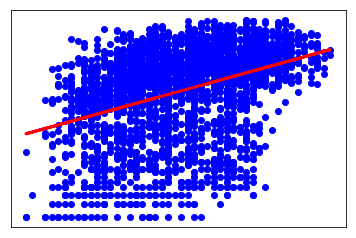

In [42]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(X_train['temp'].reshape(-1, 1), y_train)

y_pred = regr.predict(X_val['temp'].reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
baseline_RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
baseline_RMSE_CV = rmse_cv(linear_model.LinearRegression(), X, y)
baseline_RMSE_CV = np.average(baseline_RMSE_CV)

print("Root Mean squared error: %.2f"
      % baseline_RMSE)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_val, y_pred))

# Plot outputs
plt.scatter(X_val['temp'],y_val,  color='blue')
plt.plot(X_val['temp'], y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Good, now we have a reference for a naiv model which takes the linear regression for temp vs count.<br>
**naiv linear regression RMSE** = 1.32

In [43]:
model_results_df = pd.DataFrame(columns=['model', 'RMSE', 'CV'])
model_results_df['model'] = model_results_df['model'].astype(str)
model_results_df[['RMSE', 'CV']] = model_results_df[['RMSE', 'CV']].astype(float)
i=0
model_results_df.loc[i] = ['naiv linear regression', baseline_RMSE, baseline_RMSE_CV]

### Basic tree ensemble based models with simple hyperparams

In [44]:
def run_simple_pipeline(model, random_state):
    try:
        simple_model = model(random_state=random_state)
        CV = rmse_cv(model(random_state=random_state), X, y)
    except TypeError as e:
        simple_model = model(seed=random_state)
        CV = rmse_cv(model(seed = random_state), X, y)
    CV = np.average(CV)
    simple_model.fit(X_train, y_train)
    y_pred = simple_model.predict(X_val)
    simple_model_RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    return simple_model, simple_model_RMSE, CV

In [45]:
simple_random_forest, simple_random_forest_RMSE, simple_random_forest_RMSE_CV = run_simple_pipeline(RandomForestRegressor, random_state=0)
print(f'RMSE: {simple_random_forest_RMSE}, CV:{simple_random_forest_RMSE_CV}')

RMSE: 0.32763509950713954, CV:0.4739044853414681


So for a simple random forest model:<br>
**simple random forest RMSE** = 0.3276

In [46]:
i += 1
model_results_df.loc[i] = ['simple random forest seed 0', simple_random_forest_RMSE, simple_random_forest_RMSE_CV]

In [47]:
simple_XGBoost, simple_XGBoost_RMSE, simple_XGBoost_RMSE_CV = run_simple_pipeline(XGBRegressor, random_state=0)
print(f'RMSE: {simple_XGBoost_RMSE}, CV:{simple_XGBoost_RMSE_CV}')

RMSE: 0.3840467860604075, CV:0.4641353588677174


for simple xgboos regressor:
**simple xgboost RMSE** = 0.38404

In [48]:
i += 1
model_results_df.loc[i] = ['simple xgboost seed 0', simple_XGBoost_RMSE, simple_XGBoost_RMSE_CV]

Lets try other random seeds

In [49]:
simple_random_forest_475, simple_random_forest_RMSE_475, simple_random_forest_RMSE_CV_475 = run_simple_pipeline(RandomForestRegressor, random_state=475)
print(f'RMSE: {simple_random_forest_RMSE_475}, CV:{simple_random_forest_RMSE_CV_475}')

RMSE: 0.3275943818716689, CV:0.46555753309965925


In [50]:
i += 1
model_results_df.loc[i] = ['simple random forest seed 475', simple_random_forest_RMSE_475, simple_random_forest_RMSE_CV_475]

In [51]:
simple_XGBoost_475, simple_XGBoost_RMSE_475, simple_XGBoost_RMSE_CV_475 = run_simple_pipeline(XGBRegressor, random_state=475)
print(f'RMSE: {simple_XGBoost_RMSE_475}, CV:{simple_XGBoost_RMSE_CV_475}')

RMSE: 0.3840467860604075, CV:0.4641353588677174


In [52]:
i += 1
model_results_df.loc[i] = ['simple xgboost seed 475', simple_XGBoost_RMSE_475, simple_XGBoost_RMSE_CV_475]

In [53]:
simple_random_forest_887, simple_random_forest_RMSE_887, simple_random_forest_RMSE_CV_887 = run_simple_pipeline(RandomForestRegressor, random_state=887)
print(f'RMSE: {simple_random_forest_RMSE_887}, CV:{simple_random_forest_RMSE_CV_887}')

RMSE: 0.3333710826883618, CV:0.4665788309852575


In [54]:
i += 1
model_results_df.loc[i] = ['simple random forest seed 887', simple_random_forest_RMSE_887, simple_random_forest_RMSE_CV_887]

In [55]:
simple_XGBoost_887, simple_XGBoost_RMSE_887, simple_XGBoost_RMSE_CV_887 = run_simple_pipeline(XGBRegressor, random_state=887)
print(f'RMSE: {simple_XGBoost_RMSE_887}, CV:{simple_XGBoost_RMSE_CV_887}')

RMSE: 0.3840467860604075, CV:0.4641353588677174


In [56]:
i += 1
model_results_df.loc[i] = ['simple xgboost seed 887', simple_XGBoost_RMSE_887, simple_XGBoost_RMSE_CV_887]

Seems that in all the random states that we tested random forest outperformed xgboost.

### Hyper parameter search

Things to try:
* running TPOT a number of times
* running TPOT with different generations and population sizes
* think of ways to capture seasonality (count over the different seasons, count over hours) + trend (increase in count over the years)
    - training the model first on 2011 untill overfitting, then on 2011 + 2012: **NOT A GOOD IDEA ON TREE BASED MODELS!**

**TPOT** is an automated pipeline generator based on genetic algorithms.
<br><br>
It searches through multiple tree based models and parameters along with some feature selection methods and outputs the best pipeline that it found.
I will use this library for fast iteration over hyperparameters.

In [57]:
# from tpot import TPOTRegressor
# from sklearn.datasets import load_boston
# from sklearn.model_selection import train_test_split
# 
# tpot = TPOTRegressor(generations=9, population_size=30, verbosity=2)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_val, y_val))
# tpot.export('tpot_boston_pipeline_4_9gen_30pop.py')

Below I will list outputs of different TPOT runs: (note that the pipelines are saved in python files)

**tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)**

1. Best pipeline: XGBRegressor(SelectPercentile(input_matrix, percentile=87), learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.65)    -0.000150797646945

2. Best pipeline: ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=100), bootstrap=False, max_features=0.8, min_samples_leaf=6, min_samples_split=5, n_estimators=100)
-0.000151615129883

3. Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.85, min_samples_leaf=1, min_samples_split=13, n_estimators=100)
-0.000259734443071

4. Best pipeline: ExtraTreesRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, max_features=0.75, min_samples_leaf=3, min_samples_split=7, n_estimators=100)
-0.000223451917089

**tpot = TPOTRegressor(generations=7, population_size=20, verbosity=2)**

1. Best pipeline: XGBRegressor(ZeroCount(input_matrix), learning_rate=0.1, max_depth=8, min_child_weight=16, n_estimators=100, nthread=1, subsample=1.0)
-0.000229089893118

2. Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.1)
-0.000567397464753

3. Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.95, min_samples_leaf=1, min_samples_split=11, n_estimators=100)
-0.000172377228275

4. Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.75, learning_rate=0.1, loss=ls, max_depth=10, max_features=0.8, min_samples_leaf=8, min_samples_split=13, n_estimators=100, subsample=0.85)
-0.000130923469254

**tpot = TPOTRegressor(generations=9, population_size=30, verbosity=2)**

1. Best pipeline: XGBRegressor(CombineDFs(MaxAbsScaler(input_matrix), input_matrix), learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.8)
-0.000114176476891

2. Best pipeline: XGBRegressor(SelectPercentile(input_matrix, percentile=23), learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.95)
-0.000145220541337

3. Best pipeline: GradientBoostingRegressor(MinMaxScaler(input_matrix), alpha=0.8, learning_rate=0.1, loss=ls, max_depth=7, max_features=0.8, min_samples_leaf=4, min_samples_split=19, n_estimators=100, subsample=0.9)
-0.000157425797636

4.  Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=100, nthread=1, subsample=1.0)
-0.00020283144405
<br><br>
Looks like destiny chose **XGBRegressor** for us...
<br><br>
**Lets have a look at all XGBRegressor hyperparameters:**
<br>
> * learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=100, nthread=1, subsample=1.0
> * learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.95
> * learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.8
> * learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.1
> * learning_rate=0.1, max_depth=8, min_child_weight=16, n_estimators=100, nthread=1, subsample=1.0
> * learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.65

Accordidng to the above hyperparameters averages (excluding outliars), we will choose:<br>
learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88

In [58]:
TPOT_xgb = XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0)
TPOT_xgb.fit(X_train,y_train, eval_metric='rmse', eval_set=[(X_train, y_train),(X_val, y_val)], verbose=True, learning_rates=None)

[0]	validation_0-rmse:3.90082	validation_1-rmse:3.9212
[1]	validation_0-rmse:3.5189	validation_1-rmse:3.53797
[2]	validation_0-rmse:3.17586	validation_1-rmse:3.19425
[3]	validation_0-rmse:2.86694	validation_1-rmse:2.8848
[4]	validation_0-rmse:2.58924	validation_1-rmse:2.60603
[5]	validation_0-rmse:2.33797	validation_1-rmse:2.35481
[6]	validation_0-rmse:2.1129	validation_1-rmse:2.12994
[7]	validation_0-rmse:1.91066	validation_1-rmse:1.92739
[8]	validation_0-rmse:1.72826	validation_1-rmse:1.74557
[9]	validation_0-rmse:1.56483	validation_1-rmse:1.58331
[10]	validation_0-rmse:1.4183	validation_1-rmse:1.43826
[11]	validation_0-rmse:1.28663	validation_1-rmse:1.30756
[12]	validation_0-rmse:1.1672	validation_1-rmse:1.18911
[13]	validation_0-rmse:1.05952	validation_1-rmse:1.08329
[14]	validation_0-rmse:0.962961	validation_1-rmse:0.9882
[15]	validation_0-rmse:0.876268	validation_1-rmse:0.903904
[16]	validation_0-rmse:0.798322	validation_1-rmse:0.828294
[17]	validation_0-rmse:0.728102	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.88)

Lets compare with the RMSE function that we used earlier:

In [59]:
y_pred = TPOT_xgb.predict(X_val)
TPOT_xgb_RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
TPOT_xgb_CV = rmse_cv(XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0), X, y)
TPOT_xgb_CV = np.average(TPOT_xgb_CV)
print(f'RMSE: {TPOT_xgb_RMSE}, CV: {TPOT_xgb_CV}')

RMSE: 0.2926877897857523, CV: 0.398495871042695


In [60]:
i += 1
model_results_df.loc[i] = ['TPOT xgb', TPOT_xgb_RMSE, TPOT_xgb_CV]

Same results as in the output.<br>
This is indeed an improvement from the "simple" model.<br>
There still seems to be some significant overfitting.

Lets compare with a random forest with the same hyper params:

In [61]:
TPOT_randomf = RandomForestRegressor(max_depth=9, criterion='mse', min_samples_split=4, n_estimators=100, n_jobs=1, verbose=1, random_state=0)
TPOT_randomf.fit(X_train,y_train)
y_pred = TPOT_randomf.predict(X_val)
TPOT_randomf_RMSE = np.sqrt(mean_squared_error(y_pred, y_val))
TPOT_randomf_CV = rmse_cv(RandomForestRegressor(max_depth=9, criterion='mse', min_samples_split=4, n_estimators=100, n_jobs=1, verbose=1, random_state=0), X, y)
TPOT_randomf_CV = np.average(TPOT_randomf_CV)
print(f'RMSE: {TPOT_randomf_RMSE}, CV: {TPOT_randomf_CV}')

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


RMSE: 0.37008293392176117, CV: 0.4916007695096928


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [62]:
i += 1
model_results_df.loc[i] = ['TPOT randomf', TPOT_randomf_RMSE, TPOT_randomf_CV]

Much higher than our TPOTed xgboost model

We will use cosine annealing for the learning rate.<br>
Unfortunately XGBRegressors fit function does not support it, however the learn function does.<br>
I edited the fit function to include learning rate annealing.

In [63]:
def cosine_annealing(boosting_round, num_boost_round):
    start_val = 0.1
    end_val = 0
    cos_out = np.cos(np.pi*(boosting_round)/num_boost_round) + 1
    return end_val + (start_val-end_val) / 2 * cos_out

In [64]:
TPOT_xgb_cos = XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0)
TPOT_xgb_cos.fit(X_train,y_train, eval_metric='rmse', eval_set=[(X_train, y_train),(X_val, y_val)], verbose=True, learning_rates=cosine_annealing)

[0]	validation_0-rmse:3.90082	validation_1-rmse:3.9212
[1]	validation_0-rmse:3.51899	validation_1-rmse:3.53807
[2]	validation_0-rmse:3.17628	validation_1-rmse:3.19468
[3]	validation_0-rmse:2.86801	validation_1-rmse:2.88587
[4]	validation_0-rmse:2.59129	validation_1-rmse:2.60808
[5]	validation_0-rmse:2.34136	validation_1-rmse:2.35821
[6]	validation_0-rmse:2.11795	validation_1-rmse:2.13498
[7]	validation_0-rmse:1.91763	validation_1-rmse:1.93436
[8]	validation_0-rmse:1.73748	validation_1-rmse:1.75485
[9]	validation_0-rmse:1.57636	validation_1-rmse:1.59477
[10]	validation_0-rmse:1.43212	validation_1-rmse:1.45192
[11]	validation_0-rmse:1.30298	validation_1-rmse:1.32376
[12]	validation_0-rmse:1.18639	validation_1-rmse:1.20828
[13]	validation_0-rmse:1.08212	validation_1-rmse:1.10543
[14]	validation_0-rmse:0.987893	validation_1-rmse:1.01266
[15]	validation_0-rmse:0.902624	validation_1-rmse:0.929348
[16]	validation_0-rmse:0.827163	validation_1-rmse:0.856434
[17]	validation_0-rmse:0.759393	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.88)

In [65]:
y_pred = TPOT_xgb_cos.predict(X_val)
TPOT_xgb_cosine_RMSE = np.sqrt(mean_squared_error(y_pred, y_val))
print(f'RMSE: {TPOT_xgb_cosine_RMSE}, CV: Not relevant')

RMSE: 0.29970967506863117, CV: Not relevant


In [66]:
i += 1
model_results_df.loc[i] = ['TPOT xgb cosine', TPOT_xgb_cosine_RMSE, np.nan]

It looks like we got a worse score when using cosine annealing then when using 0.1 learning rate.

### Feature Importance

Now that we have a somwhat optimal model with good hyperparameters, lets look at the feature importance to see if the features we created were usefull at all. Accordingly we will knonw if to do further feature engineering.

**wight**: the number of splits the feature was used for<br>
**gain**: metric based on the gain for each split

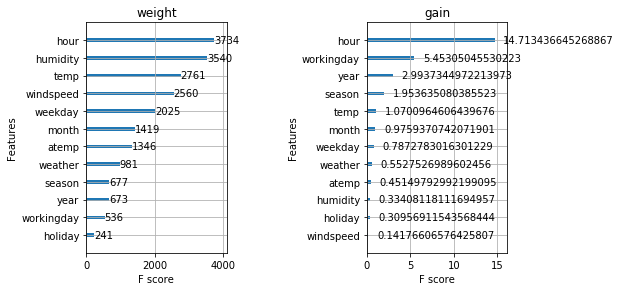

In [67]:
from xgboost import plot_importance
fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.1, top=0.9, wspace=1, hspace=0.2)
plot_importance(TPOT_xgb, importance_type='weight', ax=axs[0], title='weight')
plot_importance(TPOT_xgb, importance_type='gain', ax=axs[1], title='gain')

Lets have a look at our engineered features:<br>

**hour**:<br>
It seems that the hour feature we created is very prominant, in the number of splits and in the weight.<br>
This agrees with the relatively smooth but voilatile function.<br>
<br>
**year**:<br>
In addition, we see that although year was not used much as a splitter, it has much gain (perhaps it was used high up in the tree), this too is good news.<br>
<br>
**weekday**:<br>
weekday was used very often but did not add much gain.<br>
<br>

Lets look at some features which are not ours:<br>

**holiday**:<br>
This feature would have made a difference on casual and therefore I would expect that this has some gain but it seems not....<br>
Probably because that I removed the casual and registered columns.<br>
<br>
**workingday**:<br>
As in holiday, here to I would expect workingday to have some influence on casual.<br>
This feature on the other hand DID have some significant gain.<br>

### Decide if casual and registered features are needed

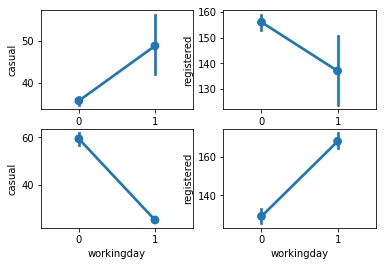

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.pointplot(x="holiday", y="casual", data=df_train_with_datetime_casual_registered, ax=axs[0][0])
sns.pointplot(x="holiday", y="registered", data=df_train_with_datetime_casual_registered, ax=axs[0][1])
sns.pointplot(x="workingday", y="casual", data=df_train_with_datetime_casual_registered, ax=axs[1][0])
sns.pointplot(x="workingday", y="registered", data=df_train_with_datetime_casual_registered, ax=axs[1][1])

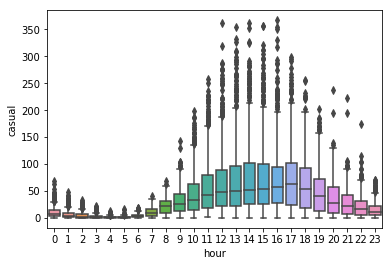

In [69]:
sns.boxplot(x=df_train_with_datetime_casual_registered['hour'], y=df_train_with_datetime_casual_registered['casual'])

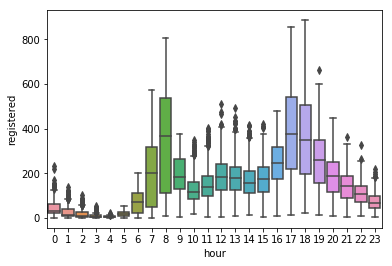

In [70]:
sns.boxplot(x=df_train_with_datetime_casual_registered['hour'], y=df_train_with_datetime_casual_registered['registered'])

### Model using two seperate models for registered and casual

In [71]:
df_train_casual_reg = df_train_with_datetime_casual_registered.drop(columns=['datetime', 'count'])

In [72]:
X_cas_reg = df_train_casual_reg.drop(columns=['casual', 'registered'])
y_cas = df_train_casual_reg['casual']
y_reg = df_train_casual_reg['registered']
X_train_cas, X_val_cas, y_train_cas, y_val_cas = train_test_split(X_cas_reg, y_cas, train_size=0.75, test_size=0.25, random_state=0)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_cas_reg, y_reg, train_size=0.75, test_size=0.25, random_state=0)

In [73]:
X_train_cas.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,weekday
count,8164.000000,8164.000000,8164.000000,8164.00000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.496570,0.029030,0.679936,1.41389,20.137509,23.551758,61.836722,12.832602,2011.501715,6.496938,11.554998,3.020333
std,1.118645,0.167901,0.466529,0.63025,7.776977,8.463277,19.239196,8.262360,0.500028,3.454663,6.929567,2.007783
min,1.000000,0.000000,0.000000,1.00000,0.820000,2.275000,0.000000,0.000000,2011.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.00000,13.940000,16.665000,47.000000,7.001500,2011.000000,3.000000,6.000000,1.000000
50%,2.000000,0.000000,1.000000,1.00000,20.500000,24.240000,62.000000,12.998000,2012.000000,6.000000,12.000000,3.000000
75%,3.000000,0.000000,1.000000,2.00000,26.240000,31.060000,77.000000,16.997900,2012.000000,9.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.00000,41.000000,45.455000,100.000000,56.996900,2012.000000,12.000000,23.000000,6.000000


In [74]:
X_train_reg.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,weekday
count,8164.000000,8164.000000,8164.000000,8164.00000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.496570,0.029030,0.679936,1.41389,20.137509,23.551758,61.836722,12.832602,2011.501715,6.496938,11.554998,3.020333
std,1.118645,0.167901,0.466529,0.63025,7.776977,8.463277,19.239196,8.262360,0.500028,3.454663,6.929567,2.007783
min,1.000000,0.000000,0.000000,1.00000,0.820000,2.275000,0.000000,0.000000,2011.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.00000,13.940000,16.665000,47.000000,7.001500,2011.000000,3.000000,6.000000,1.000000
50%,2.000000,0.000000,1.000000,1.00000,20.500000,24.240000,62.000000,12.998000,2012.000000,6.000000,12.000000,3.000000
75%,3.000000,0.000000,1.000000,2.00000,26.240000,31.060000,77.000000,16.997900,2012.000000,9.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.00000,41.000000,45.455000,100.000000,56.996900,2012.000000,12.000000,23.000000,6.000000


Good, looks like the X are the same for both

In [75]:
y_train_cas.describe()

count    8164.000000
mean       35.762371
std        49.826465
min         0.000000
25%         4.000000
50%        16.000000
75%        48.000000
max       367.000000
Name: casual, dtype: float64

In [76]:
y_train_reg.describe()

count    8164.000000
mean      154.923199
std       151.318558
min         0.000000
25%        36.000000
50%       116.000000
75%       223.000000
max       886.000000
Name: registered, dtype: float64

In [77]:
cas_xgb = XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0)
cas_xgb.fit(X_train_cas,y_train_cas, eval_metric='rmse', eval_set=[(X_train_cas, y_train_cas),(X_val_cas, y_val_cas)], verbose=True, learning_rates=None)
# cas_xgb_CV_log = rmse_cv(XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0), X_cas_reg, y_cas, log=True)
# cas_xgb_CV_log = np.average(cas_xgb_CV_log)
# print(f'CV: {cas_xgb_CV_log}')

[0]	validation_0-rmse:55.6787	validation_1-rmse:56.687
[1]	validation_0-rmse:50.8033	validation_1-rmse:51.8855
[2]	validation_0-rmse:46.4339	validation_1-rmse:47.5747
[3]	validation_0-rmse:42.5119	validation_1-rmse:43.6944
[4]	validation_0-rmse:38.992	validation_1-rmse:40.2645
[5]	validation_0-rmse:35.7959	validation_1-rmse:37.0909
[6]	validation_0-rmse:32.9383	validation_1-rmse:34.206
[7]	validation_0-rmse:30.3619	validation_1-rmse:31.6849
[8]	validation_0-rmse:28.093	validation_1-rmse:29.5527
[9]	validation_0-rmse:26.0136	validation_1-rmse:27.5876
[10]	validation_0-rmse:24.1737	validation_1-rmse:25.8892
[11]	validation_0-rmse:22.5168	validation_1-rmse:24.3578
[12]	validation_0-rmse:21.0496	validation_1-rmse:23.0536
[13]	validation_0-rmse:19.7216	validation_1-rmse:21.8822
[14]	validation_0-rmse:18.5346	validation_1-rmse:20.876
[15]	validation_0-rmse:17.4744	validation_1-rmse:19.984
[16]	validation_0-rmse:16.5421	validation_1-rmse:19.2279
[17]	validation_0-rmse:15.6915	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.88)

the low results are probably because that I did not log the target value...

In [78]:
reg_xgb = XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0)
reg_xgb.fit(X_train_reg,y_train_reg, eval_metric='rmse', eval_set=[(X_train_reg, y_train_reg),(X_val_reg, y_val_reg)], verbose=True, learning_rates=None)
# reg_xgb_CV_log = rmse_cv(XGBRegressor(learning_rate=0.1,max_depth=9, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.88, silent=False, seed=0), X_cas_reg, y_reg, log=True)
# reg_xgb_CV_log = np.average(reg_xgb_CV_log)
# print(f'CV: {reg_xgb_CV_log}')

[0]	validation_0-rmse:195.788	validation_1-rmse:196.702
[1]	validation_0-rmse:177.448	validation_1-rmse:178.304
[2]	validation_0-rmse:160.995	validation_1-rmse:161.909
[3]	validation_0-rmse:146.23	validation_1-rmse:147.006
[4]	validation_0-rmse:132.914	validation_1-rmse:133.646
[5]	validation_0-rmse:120.991	validation_1-rmse:121.664
[6]	validation_0-rmse:110.263	validation_1-rmse:111.109
[7]	validation_0-rmse:100.686	validation_1-rmse:101.73
[8]	validation_0-rmse:92.1383	validation_1-rmse:93.3551
[9]	validation_0-rmse:84.473	validation_1-rmse:86.0075
[10]	validation_0-rmse:77.589	validation_1-rmse:79.404
[11]	validation_0-rmse:71.3416	validation_1-rmse:73.3673
[12]	validation_0-rmse:65.7662	validation_1-rmse:68.1369
[13]	validation_0-rmse:60.8051	validation_1-rmse:63.5914
[14]	validation_0-rmse:56.3173	validation_1-rmse:59.3991
[15]	validation_0-rmse:52.3667	validation_1-rmse:55.6664
[16]	validation_0-rmse:48.8741	validation_1-rmse:52.5329
[17]	validation_0-rmse:45.7391	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=False,
       subsample=0.88)

In [79]:
cas_pred = cas_xgb.predict(X_val_cas)
reg_pred = reg_xgb.predict(X_val_reg)
cas_reg_count_pred = cas_pred + reg_pred
cas_reg_count_pred

array([ 265.63549805,  381.50476074,  238.5987854 , ...,  472.67745972,
        324.34875488,   17.31675529], dtype=float32)

In [80]:
np.any(cas_reg_count_pred < 0)

True

Seems we have some negativity issues...<br>
Lets just replace them with  0

In [81]:
cas_reg_count_pred[cas_reg_count_pred < 0] = 0
cas_reg_count_pred_log = np.log1p(cas_reg_count_pred)
np.any(np.isnan(cas_reg_count_pred_log))

False

In [82]:
cas_reg_count_MSE = np.sqrt(mean_squared_error(cas_reg_count_pred_log, y_val))
# cas_reg_count_CV = (reg_xgb_CV_log + cas_xgb_CV_log) / 2
print(f'MSE: {cas_reg_count_MSE}, CV: not applicable')

MSE: 0.32942814771441237, CV: not applicable


In [83]:
i += 1
model_results_df.loc[i] = ['addition of casual and registered', cas_reg_count_MSE, np.nan]

Doesnt look that promising, but perhaps this is because that we did not optimize hiperparameters for these specific cases...

Lets look at feature importance on both of our models

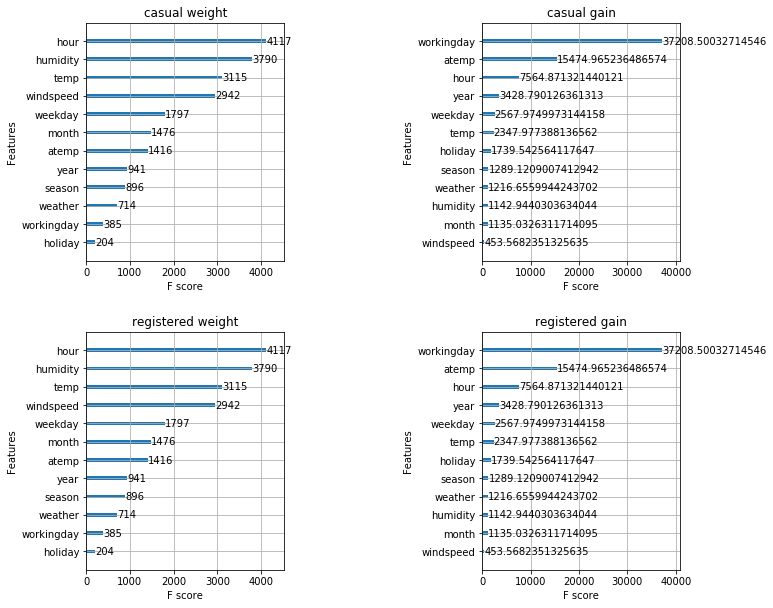

In [84]:
fig, axs = plt.subplots(ncols=2, nrows=2)
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.5, top=2, wspace=1, hspace=0.3)
plot_importance(cas_xgb, importance_type='weight', ax=axs[0][0], title='casual weight')
plot_importance(cas_xgb, importance_type='gain', ax=axs[0][1], title='casual gain')
plot_importance(cas_xgb, importance_type='weight', ax=axs[1][0], title='registered weight')
plot_importance(cas_xgb, importance_type='gain', ax=axs[1][1], title='registered gain')

Interesting that working day contributed much gain though **holiday** contribute much less gain.<br>
This is probably because what really matters is not that it is a holiday, but that it is not a working day.

## Submit

Lets summarize the different results we got from different models, submit to kaggle the different samples and we will see which is the best on the kaggle test set.

In [85]:
model_results_df.sort_values(by=['RMSE'],inplace=True)
model_results_df.head(5)

,model,RMSE,CV
7,TPOT xgb,0.292688,0.398496
9,TPOT xgb cosine,0.299710,NaN
3,simple random forest seed 475,0.327594,0.465558
1,simple random forest seed 0,0.327635,0.473904
10,addition of casual and registered,0.329428,NaN


In [86]:
model_results_df.sort_values(by=['CV'],inplace=True)
model_results_df.head(5)

,model,RMSE,CV
7,TPOT xgb,0.292688,0.398496
2,simple xgboost seed 0,0.384047,0.464135
4,simple xgboost seed 475,0.384047,0.464135
6,simple xgboost seed 887,0.384047,0.464135
3,simple random forest seed 475,0.327594,0.465558


Top 5 performers in MSE are:
1. TPOT xgb
2. TPOT xgb cosine
3. simple random forest seed 475
4. simple random forest seed 0
5. addition of casual and registered

Top 5 performers in CV are:
1. TPOT xgb
2. simple xgboost seed 0
3. simple xgboost seed 475
4. TPOT xgb cosine
5. addition of casual and registered

I put **TPOT xgb cosine** and **addition of casual and registered** in the top 5 CV because that I would like to see how
they perform on the kaggle test set + I assume they would have relative high CV score as well.

In [101]:
def remove_negatives(res):
    num = res._get_numeric_data()
    num[num < 0] = 0

In [102]:
TPOT_xgb.fit(X,y, eval_metric='rmse', verbose=True, learning_rates=None)
TPOT_xgb_preds = np.expm1(TPOT_xgb.predict(df_test))
TPOT_xgb_res = pd.DataFrame()
TPOT_xgb_res['datetime'] = test_datetime
TPOT_xgb_res['count'] = pd.Series(TPOT_xgb_preds)
remove_negatives(TPOT_xgb_res)
TPOT_xgb_res.head()

,datetime,count
0,2011-01-20 00:00:00,11.180670
1,2011-01-20 01:00:00,4.462249
2,2011-01-20 02:00:00,3.999539
3,2011-01-20 03:00:00,3.106581
4,2011-01-20 04:00:00,2.750082


In [103]:
TPOT_xgb_cos.fit(X,y, eval_metric='rmse', verbose=True, learning_rates=cosine_annealing)
TPOT_xgb_cos_preds = np.expm1(TPOT_xgb_cos.predict(df_test))
TPOT_xgb_cos_res = pd.DataFrame()
TPOT_xgb_cos_res['datetime'] = test_datetime
TPOT_xgb_cos_res['count'] = pd.Series(TPOT_xgb_cos_preds)
remove_negatives(TPOT_xgb_cos_res)
TPOT_xgb_cos_res.head()

,datetime,count
0,2011-01-20 00:00:00,9.816828
1,2011-01-20 01:00:00,4.307828
2,2011-01-20 02:00:00,3.633546
3,2011-01-20 03:00:00,2.974400
4,2011-01-20 04:00:00,2.733811


In [104]:
simple_random_forest_475.fit(X,y)
simple_random_forest_475_preds = np.expm1(simple_random_forest_475.predict(df_test))
simple_random_forest_475_res = pd.DataFrame()
simple_random_forest_475_res['datetime'] = test_datetime
simple_random_forest_475_res['count'] = pd.Series(simple_random_forest_475_preds)
remove_negatives(simple_random_forest_475_res)
simple_random_forest_475_res.head()

,datetime,count
0,2011-01-20 00:00:00,9.052211
1,2011-01-20 01:00:00,5.194289
2,2011-01-20 02:00:00,3.187757
3,2011-01-20 03:00:00,3.254707
4,2011-01-20 04:00:00,2.393458


In [105]:
simple_random_forest.fit(X,y)
simple_random_forest_preds = np.expm1(simple_random_forest.predict(df_test))
simple_random_forest_res = pd.DataFrame()
simple_random_forest_res['datetime'] = test_datetime
simple_random_forest_res['count'] = pd.Series(simple_random_forest_preds)
remove_negatives(simple_random_forest_res)
simple_random_forest_res.head()

,datetime,count
0,2011-01-20 00:00:00,11.324281
1,2011-01-20 01:00:00,4.958883
2,2011-01-20 02:00:00,2.491940
3,2011-01-20 03:00:00,3.513679
4,2011-01-20 04:00:00,3.194927


In [106]:
cas_xgb.fit(X_cas_reg,y_cas, eval_metric='rmse', verbose=True, learning_rates=None)
reg_xgb.fit(X_cas_reg,y_reg, eval_metric='rmse', verbose=True, learning_rates=None)
cas_reg_xgb_preds = cas_xgb.predict(df_test) + reg_xgb.predict(df_test)
cas_reg_xgb_res = pd.DataFrame()
cas_reg_xgb_res['datetime'] = test_datetime
cas_reg_xgb_res['count'] = pd.Series(cas_reg_xgb_preds)
remove_negatives(cas_reg_xgb_res)
cas_reg_xgb_res.head()

,datetime,count
0,2011-01-20 00:00:00,11.086968
1,2011-01-20 01:00:00,6.300915
2,2011-01-20 02:00:00,3.247435
3,2011-01-20 03:00:00,2.756974
4,2011-01-20 04:00:00,2.817458


In [107]:
TPOT_xgb_res.to_csv('TPOT_xgb.csv', index=False)
TPOT_xgb_cos_res.to_csv('TPOT_xgb_cos.csv', index=False)
simple_random_forest_475_res.to_csv('simple_random_forest_475.csv', index=False)
simple_random_forest_res.to_csv('simple_random_forest.csv', index=False)
cas_reg_xgb_res.to_csv('cas_reg_xgb.csv', index=False)

### Kaggle Results

- **TPOT_xgb**: 0.40599
- **TPOT_xgb_cos**: 0.39846
- **simple_random_forest_475**: 0.44173
- **simple_random_forest**: 0.45470
- **cas_reg_xgb**: 0.45322


#### Summary

First place: **TPOT_xgb_cos**<br>
This is a model that was trained with hyper parameters found by a genetic algorithm + cosine annealing learning rate.
<br><br>
Second place: **TPOT_xgb**<br>
This is the same as TPOT_xgb only without the cosine annealing, using the constant learning rate found by TPOT.
<br><br>
Third place: **simple_random_fores_475**<br>
This is a random forest using the default hyper parameters, set the random seed to  be 475.